File: MUO temp filtered pulse data OR.txt — 48829 delta entries
  delta min=1.000e-06, max=4.004e-05, mean=4.721e-06
  drawing: patches=200


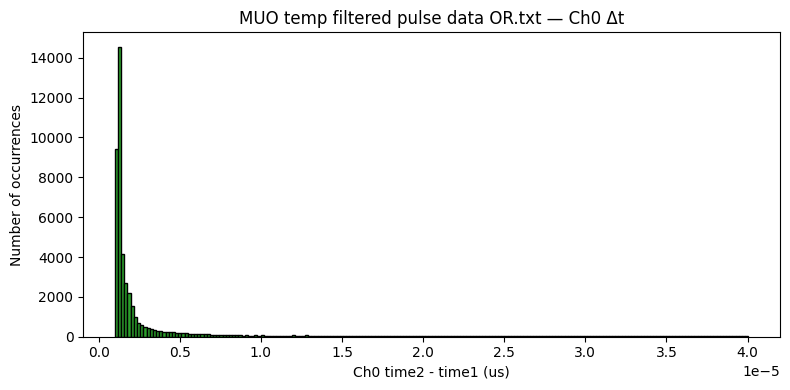

  displayed figure
Displayed 1 figure(us) inline (max_display=3).
MUO temp filtered pulse data OR.txt: 48829 detections
Bin_start	Bin_end	Count
5.284000e-06	5.290640e-06	5
5.290640e-06	5.297280e-06	2
5.297280e-06	5.303920e-06	6
5.303920e-06	5.310560e-06	26
5.310560e-06	5.317200e-06	37
5.317200e-06	5.323840e-06	20
5.323840e-06	5.330480e-06	63
5.330480e-06	5.337120e-06	94
5.337120e-06	5.343760e-06	43
5.343760e-06	5.350400e-06	105
5.350400e-06	5.357040e-06	139
5.357040e-06	5.363680e-06	96
5.363680e-06	5.370320e-06	233
5.370320e-06	5.376960e-06	323
5.376960e-06	5.383600e-06	211
5.383600e-06	5.390240e-06	570
5.390240e-06	5.396880e-06	1260
5.396880e-06	5.403520e-06	1247
5.403520e-06	5.410160e-06	5262
5.410160e-06	5.416800e-06	10299
5.416800e-06	5.423440e-06	6721
5.423440e-06	5.430080e-06	16840
5.430080e-06	5.436720e-06	4478
5.436720e-06	5.443360e-06	502
5.443360e-06	5.450000e-06	148
5.450000e-06	5.456640e-06	0
5.456640e-06	5.463280e-06	0
5.463280e-06	5.469920e-06	0
5.469920e-06	5.476560e-06	

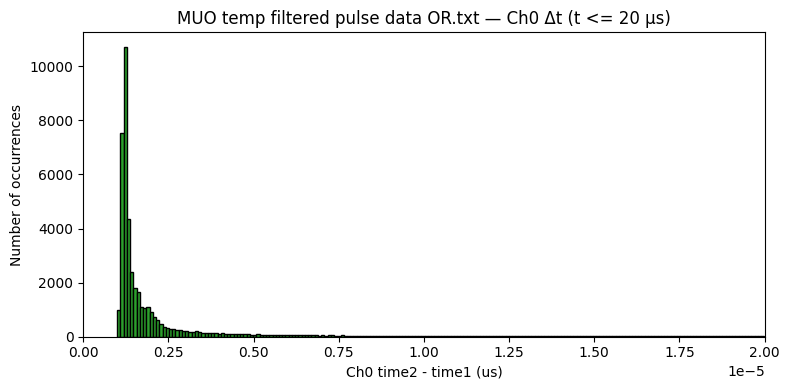

In [2]:
# Compute and plot Ch0 delta = (Ch0_time2 - Ch0_time1) per file
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import re
import math


def read_ch0_deltas_from_file(path):
    """Return DataFrame of rows with no Ch1 pulses, plus delta_t column."""
    rows = []
    header_found = False
    header_parts = None
    c0t1_idx = None
    c0t2_idx = None
    ch1_indices = []
    with open(path, 'r') as fh:
        for line in fh:
            sline = line.strip()
            if not sline:
                continue
            # detect header and record column indices; normalize and remove unit parenthesis
            if sline.startswith('Ch0_time1') or sline.startswith('Ch0_time1 (us)'):
                header_found = True
                header_clean = re.sub(r'\s*\([^)]*\)', '', sline)
                header_parts = header_clean.replace('\t', ' ').split()
                for i, tok in enumerate(header_parts):
                    tl = tok.lower()
                    if 'ch0' in tl and 'time1' in tl:
                        c0t1_idx = i
                    if 'ch0' in tl and 'time2' in tl:
                        c0t2_idx = i
                    if 'ch1' in tl and 'time' in tl:
                        ch1_indices.append(i)
                continue
            if not header_found:
                continue
            parts = sline.split()
            # if we discovered indexes from header, use them
            if c0t1_idx is not None and c0t2_idx is not None:
                if len(parts) < max(c0t1_idx, c0t2_idx) + 1:
                    continue
                try:
                    values = [float(p) for p in parts]
                except ValueError:
                    continue
                # skip if any Ch1 column has a positive value
                skip = False
                for idx in ch1_indices:
                    if idx < len(values) and values[idx] > 0:
                        skip = True
                        break
                if skip:
                    continue
                if values[c0t1_idx] > 0 and values[c0t2_idx] > 0:
                    rows.append(values)
            else:
                # fallback to legacy column positions (conservative check)
                if len(parts) < 4:
                    continue
                try:
                    values = [float(p) for p in parts]
                except ValueError:
                    continue
                # conservative check for Ch1 values in expected positions
                ch1vals = []
                for i in (6, 9):
                    if i < len(values):
                        ch1vals.append(values[i])
                if any(v > 0 for v in ch1vals):
                    continue
                if values[0] > 0 and values[3] > 0:
                    rows.append(values)
    if not rows:
        return pd.DataFrame(columns=['delta_t'])
    if header_parts is None:
        header_parts = [f'col{i}' for i in range(len(rows[0]))]
        c0t1_idx = 0
        c0t2_idx = 3
    df = pd.DataFrame(rows, columns=header_parts)
    c0t1_col = header_parts[c0t1_idx]
    c0t2_col = header_parts[c0t2_idx]
    df['delta_t'] = df[c0t2_col] - df[c0t1_col]
    return df

def read_times_from_file(path):
    """Return an array of Ch0 time1 values for rows with no Ch1 pulses."""
    times = []
    header_found = False
    c0t1_idx = None
    ch1_indices = []
    with open(path, 'r') as fh:
        for line in fh:
            sline = line.strip()
            if not sline:
                continue
            if sline.startswith('Ch0_time1') or sline.startswith('Ch0_time1 (us)'):
                header_found = True
                header_clean = re.sub(r'\s*\([^)]*\)', '', sline)
                header_parts = header_clean.replace('\t',' ').split()
                for i, tok in enumerate(header_parts):
                    tl = tok.lower()
                    if 'ch0' in tl and 'time1' in tl:
                        c0t1_idx = i
                    if 'ch1' in tl and 'time' in tl:
                        ch1_indices.append(i)
                continue
            if not header_found:
                continue
            parts = sline.split()
            if c0t1_idx is not None:
                try:
                    c0t1 = float(parts[c0t1_idx])
                except (ValueError, IndexError):
                    continue
                skip = False
                for idx in ch1_indices:
                    try:
                        v = float(parts[idx])
                    except (ValueError, IndexError):
                        v = 0.0
                    if v > 0:
                        skip = True
                        break
                if skip:
                    continue
                if c0t1 > 0:
                    times.append(c0t1)
            else:
                # fallback to first column and conservative Ch1 checks
                try:
                    c0t1 = float(parts[0])
                except ValueError:
                    continue
                ch1vals = []
                for i in (6, 9):
                    try:
                        ch1vals.append(float(parts[i]))
                    except Exception:
                        pass
                if any(v > 0 for v in ch1vals):
                    continue
                if c0t1 > 0:
                    times.append(c0t1)
    return np.array(times)


def plot_ch0_delta_per_file(data_dir='Data', bins=100, save=False, show=True, max_display=3):
    """Plot histograms for Ch0 delta, skipping rows with Ch1 contributions.
    max_display: maximum number of figures to display inline (avoid huge outputs)."""
    p = Path(data_dir)
    txt_files = sorted(p.glob('*.txt'))
    if not txt_files:
        print('No .txt files found in', data_dir)
        return
    displayed = 0
    for f in txt_files:
        df = read_ch0_deltas_from_file(f)
        if df.empty:
            print(f"File: {f.name} — 0 delta entries")
            print('  No valid Ch0 pairs found; skipping.')
            continue
        deltas = df['delta_t'].to_numpy()
        print(f"File: {f.name} — {deltas.size} delta entries")
        # diagnostic stats
        print(f"  delta min={deltas.min():.3e}, max={deltas.max():.3e}, mean={deltas.mean():.3e}")
        fig, ax = plt.subplots(figsize=(8,4))
        ax.hist(deltas, bins=bins, color='C2', edgecolor='k')
        ax.set_xlabel('Ch0 time2 - time1 (us)')
        ax.set_ylabel('Number of occurrences')
        ax.set_title(f.name + ' — Ch0 Δt')
        fig.tight_layout()
        # number of patches indicates bars drawn
        try:
            n_patches = len(ax.patches)
        except Exception:
            n_patches = None
        print(f"  drawing: patches={n_patches}")
        if save:
            out = f.with_name(f'hist_delta_{f.stem}.png')
            fig.savefig(out)
            print('  Saved', out.name)
        if show:
            if displayed < max_display:
                try:
                    fig.canvas.draw()
                except Exception:
                    pass
                try:
                    display(fig)
                    print('  displayed figure')
                    displayed += 1
                except Exception as e:
                    print('  display failed:', repr(e))
                    try:
                        plt.show()
                        print('  plt.show() called')
                        displayed += 1
                    except Exception as e2:
                        print('  plt.show() also failed:', repr(e2))
            else:
                print('  skipping inline display (max_display reached)')
        plt.close(fig)
    print(f"Displayed {displayed} figure(us) inline (max_display={max_display}).")

# Run the delta plots for all files (do not save images; display inline)
plot_ch0_delta_per_file('Data', bins=200, save=False, show=True, max_display=3)

for f in sorted(Path('Data').glob('*.txt')):
    ch0 = read_times_from_file(f)
    total = ch0.size 
    print(f"{f.name}: {total} detections")
    counts, edges = np.histogram(ch0, bins=50)
    print("Bin_start\tBin_end\tCount")
    for start, end, count in zip(edges[:-1], edges[1:], counts):
        print(f"{start:.6e}\t{end:.6e}\t{count}")

# --- New: plot OR file clipped to 20 us ---
p_or = Path('Data') / 'MUO temp filtered pulse data OR.txt'
df_or = read_ch0_deltas_from_file(p_or)
print(f'OR file deltas total: {df_or.shape[0]}')
tmax = 20e-6
deltas_or_clip = df_or['delta_t'][df_or['delta_t'] <= tmax]
print(f'deltas <= {tmax} s: {deltas_or_clip.size}')
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(deltas_or_clip, bins=200, color='C2', edgecolor='k')
ax.set_xlim(0, tmax)
ax.set_xlabel('Ch0 time2 - time1 (us)')
ax.set_ylabel('Number of occurrences')
ax.set_title(f'{p_or.name} — Ch0 Δt (t <= {tmax*1e6:.0f} µs)')
fig.tight_layout()
display(fig)
plt.close(fig)

In [3]:

## cutflow functions for DataFrame-based analysis (if we switch to pandas later)

def cut_low_voltage(df, threshold1=0.5, threshold2=0.5):
    """Return a DataFrame with rows removed where Ch0_amp1 or Ch0_amp2 is below the threshold."""
    if 'Ch0_amp1' in df.columns and 'Ch0_amp2' in df.columns:
        return df[(df['Ch0_amp1'] >= threshold1) & (df['Ch0_amp2'] >= threshold2)]
    else:
        print('Warning: Ch0_amp1 or Ch0_amp2 columns not found; returning original DataFrame')
        return df


def cut_time_window(df, dt_min=None, dt_max=None):
    """Return a DataFrame filtered by a delta_t window."""
    if 'delta_t' not in df.columns:
        if 'Ch0_time1' in df.columns and 'Ch0_time2' in df.columns:
            df = df.copy()
            df['delta_t'] = df['Ch0_time2'] - df['Ch0_time1']
        else:
            print('Warning: delta_t or time columns not found; returning original DataFrame')
            return df
    if dt_min is not None:
        df = df[df['delta_t'] >= dt_min]
    if dt_max is not None:
        df = df[df['delta_t'] <= dt_max]
    return df


def subtract_noise(df, bins=50, delta_t_bkg_only=20e-6, dt_min=None, dt_max=None):
    """Return background-subtracted delta_t histogram and background rate.
    Returns: (counts_sub, edges, bkg_rate).
    dt_min/dt_max restrict the histogram window after background estimation."""
    if 'Ch0_time1' not in df.columns or 'Ch0_time2' not in df.columns:
        print('Warning: Ch0_time1 or Ch0_time2 columns not found; cannot subtract noise')
        return np.array([]), np.array([]), 0.0
    delta_t = (df['Ch0_time2'] - df['Ch0_time1']).to_numpy()
    tail = delta_t[delta_t > delta_t_bkg_only]
    if tail.size == 0:
        print('Warning: No events found with delta_t >', delta_t_bkg_only, '; cannot estimate background')
        return np.array([]), np.array([]), 0.0
    t_max = delta_t.max()
    if t_max <= delta_t_bkg_only:
        print('Warning: delta_t max <=', delta_t_bkg_only, '; cannot estimate background')
        return np.array([]), np.array([]), 0.0
    bkg_rate = tail.size / (t_max - delta_t_bkg_only)
    print(f'Estimated background rate: {bkg_rate:.3e} events/s for delta_t > {delta_t_bkg_only:.2e} s')
    if dt_min is not None:
        delta_t = delta_t[delta_t >= dt_min]
    if dt_max is not None:
        delta_t = delta_t[delta_t <= dt_max]
    counts, edges = np.histogram(delta_t, bins=bins)
    bkg_counts = bkg_rate * np.diff(edges)
    counts_sub = counts - bkg_counts
    return counts_sub, edges, bkg_rate


def build_cutflow(df, cuts):
    """Apply cuts in order and return a cutflow DataFrame.
    cuts: list of (name, function, kwargs_dict) tuples."""
    rows = []
    current = df
    rows.append({'cut': 'start', 'n_events': int(len(current))})
    for name, func, kwargs in cuts:
        current = func(current, **kwargs)
        rows.append({'cut': name, 'n_events': int(len(current))})
    cutflow = pd.DataFrame(rows)
    cutflow['eff'] = cutflow['n_events'] / max(cutflow['n_events'].iloc[0], 1)
    return cutflow, current


def write_cutflow_table(cutflow_df, path):
    """Write cutflow table to CSV."""
    cutflow_df.to_csv(path, index=False)




In [ ]:
# Example: run cutflow for one file
file_path = Path('Data') / 'MUO temp filtered pulse data OR.txt'
df_raw = read_ch0_deltas_from_file(file_path)

cuts = [
    ('low_voltage', cut_low_voltage, {'threshold1': 0.1, 'threshold2': 0.01}),
    ('time_window', cut_time_window, {'dt_min': 1.5e-6, 'dt_max': 12e-6}),
]

cutflow_df, df_after = build_cutflow(df_raw, cuts)
display(cutflow_df)
write_cutflow_table(cutflow_df, 'cutflow_table.csv')

,cut,n_events,eff
0,start,48829,1.000000
1,low_voltage,14288,0.292613
2,time_window,6421,0.131500


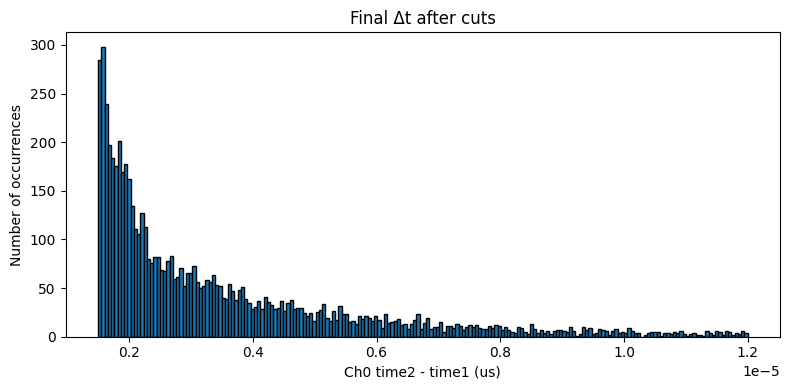

In [11]:
# Plot histogram of final DataFrame after all cuts
df_plot = df_after.copy()
if 'delta_t' not in df_plot.columns and 'Ch0_time1' in df_plot.columns and 'Ch0_time2' in df_plot.columns:
    df_plot['delta_t'] = df_plot['Ch0_time2'] - df_plot['Ch0_time1']

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(df_plot['delta_t'], bins=200, color='C0', edgecolor='k')
ax.set_xlabel('Ch0 time2 - time1 (us)')
ax.set_ylabel('Number of occurrences')
ax.set_title('Final Δt after cuts')
fig.tight_layout()
display(fig)
plt.close(fig)

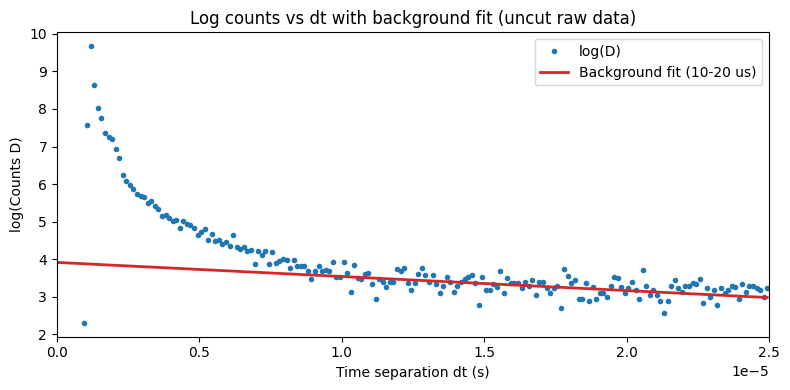

In [10]:
# Semi-log plot of counts vs dt using uncut raw data
import numpy as np
import matplotlib.pyplot as plt

# Use existing uncut raw DataFrame and ensure delta_t exists
if 'df_raw' in globals():
    df_or = df_raw
else:
    raise ValueError('df_raw not found. Run the raw data loading cell first.')
if 'delta_t' not in df_or.columns:
    if 'Ch0_time1' in df_or.columns and 'Ch0_time2' in df_or.columns:
        df_or = df_or.copy()
        df_or['delta_t'] = df_or['Ch0_time2'] - df_or['Ch0_time1']
    else:
        raise ValueError('delta_t missing and Ch0_time1/Ch0_time2 not found.')
delta_t = df_or['delta_t'].to_numpy()

# Histogram settings
bins = 200
t_min = 0.0
t_max = 25e-6
mask_range = (delta_t >= t_min) & (delta_t <= t_max)
delta_t = delta_t[mask_range]
counts, edges = np.histogram(delta_t, bins=bins, range=(t_min, t_max))
centers = 0.5 * (edges[:-1] + edges[1:])

# Background fit window (10 to 20 us) in semi-log space
bkg_min = 10e-6
bkg_max = 20e-6
bkg_mask = (centers >= bkg_min) & (centers <= bkg_max) & (counts > 0)

if np.count_nonzero(bkg_mask) < 2:
    raise ValueError('Not enough nonzero bins in background window to fit.')

# Fit log(counts) = m * t + b in the background window
log_counts_bkg = np.log(counts[bkg_mask])
fit_coeff = np.polyfit(centers[bkg_mask], log_counts_bkg, 1)
m, b = fit_coeff
log_fit = m * centers + b

# Build log(counts) for plotting (skip zero-count bins)
log_counts = np.full_like(centers, np.nan, dtype=float)
pos_mask = counts > 0
log_counts[pos_mask] = np.log(counts[pos_mask])

# Plot log(counts) and linear fit in log space
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(centers, log_counts, marker='o', linestyle='none', markersize=3, label='log(D)')
ax.plot(centers, log_fit, color='C3', linewidth=2, label='Background fit (10-20 us)')
ax.set_xlabel('Time separation dt (s)')
ax.set_ylabel('log(Counts D)')
ax.set_title('Log counts vs dt with background fit (uncut raw data)')
ax.set_xlim(t_min, t_max)
ax.legend()
fig.tight_layout()
display(fig)
plt.close(fig)

Fit range: 1.50e-06 to 1.20e-05 s
Effective lifetime tau = 1.572e-06 s +/- 5.123e-08 s
Chi2/dof = 337.98 / 76


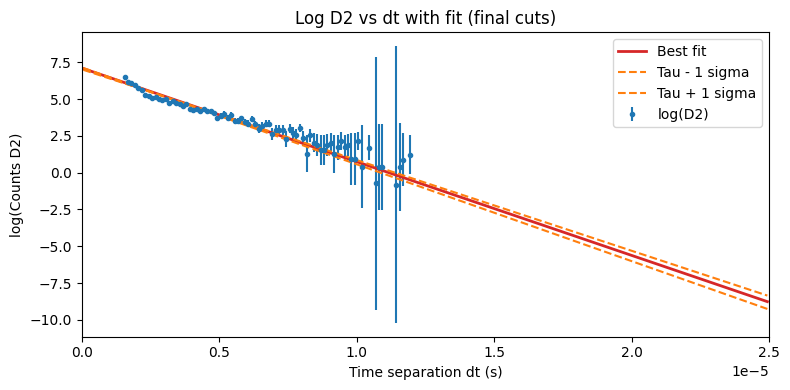

In [11]:
# Semi-log plot of D2 vs dt using final df after all cuts
import numpy as np
import matplotlib.pyplot as plt

if 'df_after' in globals():
    df_final = df_after
else:
    raise ValueError('df_after not found. Run the cutflow cell first.')
if 'delta_t' not in df_final.columns:
    if 'Ch0_time1' in df_final.columns and 'Ch0_time2' in df_final.columns:
        df_final = df_final.copy()
        df_final['delta_t'] = df_final['Ch0_time2'] - df_final['Ch0_time1']
    else:
        raise ValueError('delta_t missing and Ch0_time1/Ch0_time2 not found.')
delta_t = df_final['delta_t'].to_numpy()

# Histogram settings
bins = 200
t_min = 0.0
t_max = 25e-6
mask_range = (delta_t >= t_min) & (delta_t <= t_max)
delta_t = delta_t[mask_range]
counts, edges = np.histogram(delta_t, bins=bins, range=(t_min, t_max))
centers = 0.5 * (edges[:-1] + edges[1:])
bin_width = edges[1] - edges[0]

# Background fit window for D (used to estimate background model)
bkg_min = 10e-6
bkg_max = 20e-6
bkg_mask = (centers >= bkg_min) & (centers <= bkg_max) & (counts > 0)

if np.count_nonzero(bkg_mask) < 2:
    raise ValueError('Not enough nonzero bins in background window to fit.')

# Fit log(D) = m * t + b in the background window
log_counts_bkg = np.log(counts[bkg_mask])
fit_coeff = np.polyfit(centers[bkg_mask], log_counts_bkg, 1)
m_bkg, b_bkg = fit_coeff
bkg_fit = np.exp(m_bkg * centers + b_bkg)

# Background-subtracted counts (D2)
counts_d2 = counts - bkg_fit
counts_d2[counts_d2 < 0] = 0.0

# Errors for log(D2) (approx): sigma_D2 = sqrt(D + B)
sigma_d2 = np.sqrt(counts + bkg_fit)
log_d2 = np.full_like(centers, np.nan, dtype=float)
sigma_log_d2 = np.full_like(centers, np.nan, dtype=float)
pos_mask = counts_d2 > 0
log_d2[pos_mask] = np.log(counts_d2[pos_mask])
sigma_log_d2[pos_mask] = sigma_d2[pos_mask] / counts_d2[pos_mask]

# Fit range for log(D2)
fit_min = 1.5e-6
fit_max = 12e-6
fit_mask = (centers >= fit_min) & (centers <= fit_max) & pos_mask & np.isfinite(sigma_log_d2)
if np.count_nonzero(fit_mask) < 2:
    raise ValueError('Not enough points in fit range for D2.')

# Weighted linear fit to log(D2) = m * t + b
w = 1.0 / sigma_log_d2[fit_mask]
fit_coeff_d2, cov = np.polyfit(centers[fit_mask], log_d2[fit_mask], 1, w=w, cov=True)
m, b = fit_coeff_d2
sigma_m = np.sqrt(cov[0, 0])
tau = -1.0 / m
sigma_tau = sigma_m / (m * m)

# Normalize exponential models to the same total counts in the fit window
target_sum = np.sum(counts_d2[fit_mask])
if target_sum <= 0:
    raise ValueError('Non-positive D2 sum in fit range; cannot normalize models.')
def norm_log_model(t, tau_val):
    model = np.exp(-t / tau_val)
    scale = target_sum / np.sum(model[fit_mask])
    return np.log(scale) - t / tau_val

log_fit = m * centers + b
log_fit_hi = norm_log_model(centers, tau - sigma_tau)
log_fit_lo = norm_log_model(centers, tau + sigma_tau)

# Chi^2 in log space
resid = (log_d2[fit_mask] - (m * centers[fit_mask] + b))
chi2 = np.sum((resid / sigma_log_d2[fit_mask]) ** 2)
dof = np.count_nonzero(fit_mask) - 2
print(f'Fit range: {fit_min:.2e} to {fit_max:.2e} s')
print(f'Effective lifetime tau = {tau:.3e} s +/- {sigma_tau:.3e} s')
print(f'Chi2/dof = {chi2:.2f} / {dof}')

# Plot log(D2) with error bars and fitted lines
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(centers[pos_mask], log_d2[pos_mask], yerr=sigma_log_d2[pos_mask], fmt='o', markersize=3, label='log(D2)')
ax.plot(centers, log_fit, color='C3', linewidth=2, label='Best fit')
ax.plot(centers, log_fit_hi, color='C1', linestyle='--', label='Tau - 1 sigma')
ax.plot(centers, log_fit_lo, color='C1', linestyle='--', label='Tau + 1 sigma')
ax.set_xlabel('Time separation dt (s)')
ax.set_ylabel('log(Counts D2)')
ax.set_title('Log D2 vs dt with fit (final cuts)')
ax.set_xlim(t_min, t_max)
ax.legend()
fig.tight_layout()
display(fig)
plt.close(fig)